# 导入工具包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import torch
import librosa
import torchaudio.transforms as T
import os
from IPython.display import Audio, display

plt.style.use(['science', 'notebook', 'grid'])

In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

# 追溯最早的声纹鉴定

## 疏密波

![](records/sample.png)

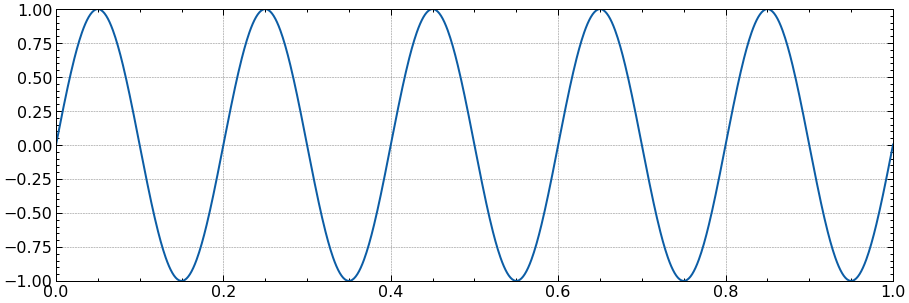

In [3]:
from scipy.io.wavfile import write


def fwaveform(amplitude, frequency, phase, xlim=(0, 1), samplerate=10000):
    t = np.linspace(*xlim, samplerate)
    return t, amplitude * np.sin(2 * np.pi * frequency * t + phase)


t, data = fwaveform(amplitude=1, frequency=5, phase=0, xlim=(0, 10), samplerate=10000)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(t, data)
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
plt.show()

scaled = np.int16(data / np.max(np.abs(data)) * np.iinfo(np.int16).max)
write('data/sin_sim.wav', len(data), scaled)

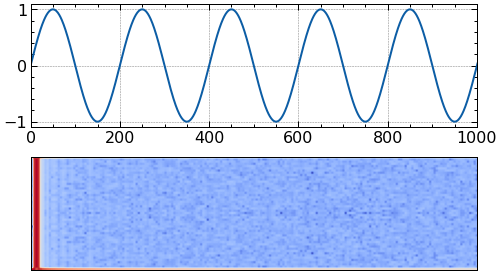

In [4]:
import torchaudio

filename = "data/sin_sim.wav"
waveform, sample_rate = torchaudio.load(filename)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))

ax = axes[0]
ax.plot(waveform.t().numpy(), )
ax.set_xlim([0, 1000])

ax = axes[1]
specgram = torchaudio.transforms.Spectrogram()(waveform)
ax.imshow(np.transpose(specgram.log2()[0, :, :].numpy()), cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_1663/1450397132.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=axs)


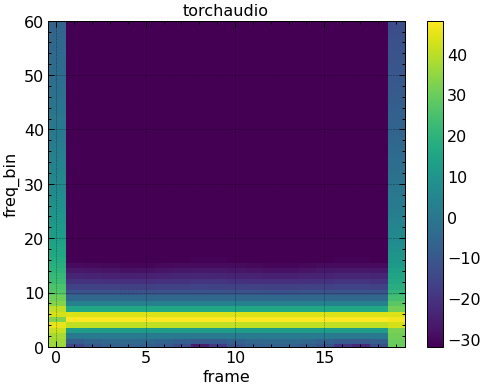

In [5]:
# define transformation
n_fft = 1024
win_length = None
hop_length = 512
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))

    axs.set_ylim([0, 60])
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


filename = "data/sin_sim.wav"
waveform, sample_rate = torchaudio.load(filename)
spec = spectrogram(waveform)
plot_spectrogram(spec[0], title='torchaudio')

## 频谱图

![](https://www.ifm.com/responsive/original/fourbythree/content/gallery/us/microsites/rtm/time-domain.png?v=-927235315)

In [6]:
play_audio(waveform, sample_rate)

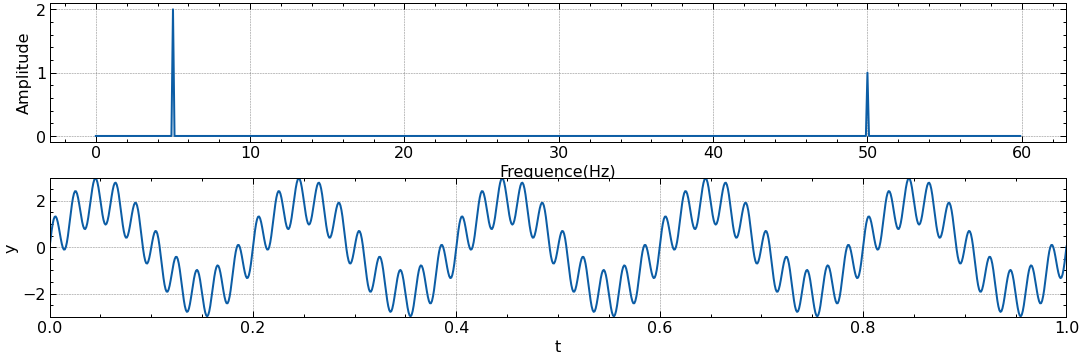

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
plt.tight_layout()

ax = axes[0]
f = np.arange(0, 60, 0.1)


def a(f):
    if f == 5:
        return 2
    elif f == 50:
        return 1
    else:
        return 0


ax.plot(f, [a(fi) for fi in f])
ax.set_xlabel("Frequence(Hz)")
ax.set_ylabel("Amplitude")

ax = axes[1]
t, wf1 = fwaveform(amplitude=2, frequency=5, phase=0, xlim=(0, 10))
t, wf2 = fwaveform(amplitude=1, frequency=50, phase=0, xlim=(0, 10))

data = wf1 + wf2
scaled = np.int16(data / np.max(np.abs(data)) * np.iinfo(np.int16).max)
write('data/sin_plx.wav', len(data), scaled)

ax.plot(t, data)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_xlim([0, 1])
ax.set_ylim([-3, 3])
plt.show()

/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_1663/1450397132.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=axs)


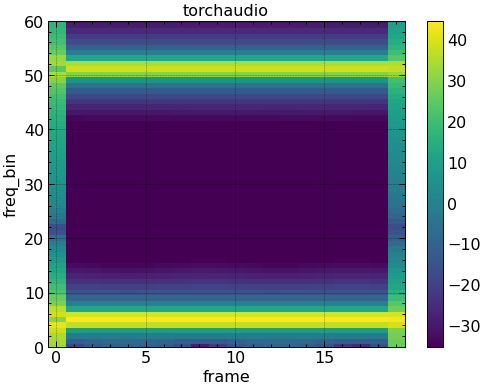

In [8]:
filename = "data/sin_plx.wav"
waveform, sample_rate = torchaudio.load(filename)
spec = spectrogram(waveform)
plot_spectrogram(spec[0], title='torchaudio')

# 听觉的非线性

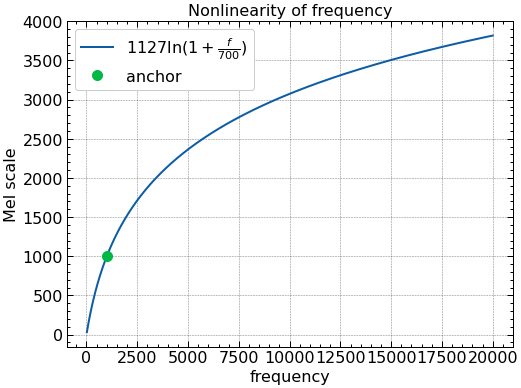

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])


def FrequencyToMel(freq):
    """Convert frequency to mel.

    Args:
        freq: the frequency in Herz, a positive floating point number

    Returns:
        a positive floating point number
    """

    return 1127 * np.log(1 + freq / 700)


x = np.arange(20, 20000, 1e-1)
y = FrequencyToMel(x)

plt.plot(x, y, label=r'$1127 \ln (1+\frac{f}{700})$')
plt.plot([1000], [1000], 'o', ms=10, label='anchor')
plt.title('Nonlinearity of frequency')
plt.xlabel('frequency')
plt.ylabel('Mel scale')
plt.legend()
plt.show()

# 音频解码器

![](http://soundfile.sapp.org/doc/WaveFormat/wav-sound-format.gif)

WAVE PCM soundfile format: http://soundfile.sapp.org/doc/WaveFormat/

音频格式与编码: https://cloud.google.com/speech-to-text/docs/encoding

将字节串解读为打包的二进制数据: https://docs.python.org/zh-cn/3/library/struct.html

NIST标准数据集的格式转换工具————sph2pipe: https://www.ldc.upenn.edu/language-resources/tools/sphere-conversion-tools

In [10]:
!ls data /

/:
Applications Users        cores        home         sbin         var
Library      Volumes      dev          opt          tmp
System       bin          etc          private      usr

data:
dr.wav                   male_audio.wav           resampled_goodorning.wav
female_audio.wav         morning.flac             sin_plx.wav
hglf.sph                 morning.mp4              sin_sim.wav
male_audio.pth           morning.wav              wxf.wav


In [11]:
import struct
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display

data = {}
samples = []

filename = 'data/male_audio.wav'
display(Audio(filename=filename))


# 默认读取 4位 little-endian 无符号整数
def reader(fin, field_size=4, format='<I'):
    return struct.unpack(format, fin.read(field_size))[0]


with open(filename, 'rb') as fin:
    # 表头区块
    data['chunk_id'] = fin.read(4)
    data['chunk_size'] = reader(fin)
    data['format'] = fin.read(4)
    # 格式区块
    data['sub_chunk_1_id'] = fin.read(4)
    data['sub_chunk_1_size'] = reader(fin)
    data['audio_format'] = reader(fin, 2, '<H')
    data['num_channels'] = reader(fin, 2, '<H')
    data['sample_rate'] = reader(fin)
    data['byte_rate'] = reader(fin)
    data['block_align'] = reader(fin, 2, '<H')
    data['bits_per_sample'] = reader(fin, 2, '<H')
    # 数据区块
    data['sub_chunk_2_id'] = fin.read(4)
    data['sub_chunk_2_size'] = reader(fin)

    bytes_per_sample = data['bits_per_sample'] / 8
    sample_count = int(data['sub_chunk_2_size'] / bytes_per_sample)
    for _ in range(sample_count):
        # H: unsigned short, h: short
        samples.append(reader(fin, 2, '<h'))

    data['length_in_seconds'] = (len(samples) / sample_rate)
    display(data)
    data['samples'] = samples

    torch.save(data, filename.replace('.wav', '.pth'))

{'chunk_id': b'RIFF',
 'chunk_size': 183898,
 'format': b'WAVE',
 'sub_chunk_1_id': b'fmt ',
 'sub_chunk_1_size': 16,
 'audio_format': 1,
 'num_channels': 1,
 'sample_rate': 44100,
 'byte_rate': 88200,
 'block_align': 2,
 'bits_per_sample': 16,
 'sub_chunk_2_id': b'data',
 'sub_chunk_2_size': 183862,
 'length_in_seconds': 9.1931}

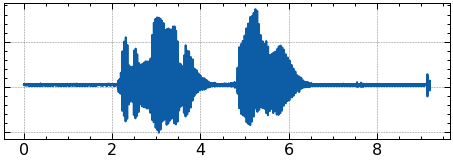

In [24]:
display(Audio(samples, rate=data['sample_rate']))
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
ax.plot(np.linspace(0, data['length_in_seconds'], len(samples)), samples)
ax.set_yticklabels('')
plt.show()

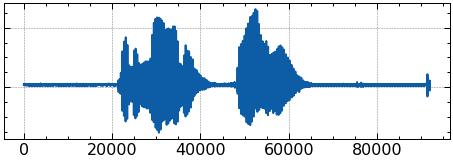

In [13]:
import torchaudio

waveform, sample_rate = torchaudio.load(filename)
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
ax.plot(waveform.t().numpy())
ax.set_yticklabels('')
plt.show()

# 音频领域的瑞士军刀

In [14]:
!ffmpeg -i data / morning.mp4 data / morning.wav -y

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/durui/opt/anaconda3 --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
data: Is a directory


In [15]:
!ls data /
!play data / morning.wav

/:
Applications Users        cores        home         sbin         var
Library      Volumes      dev          opt          tmp
System       bin          etc          private      usr

data:
dr.wav                   male_audio.wav           resampled_goodorning.wav
female_audio.wav         morning.flac             sin_plx.wav
hglf.sph                 morning.mp4              sin_sim.wav
male_audio.pth           morning.wav              wxf.wav
play FAIL formats: can't open input file `morning.wav': No such file or directory


In [16]:
!sox data / morning.wav data / morning.flac
!ls data /

sox FAIL formats: can't determine type of file `/'
/:
Applications Users        cores        home         sbin         var
Library      Volumes      dev          opt          tmp
System       bin          etc          private      usr

data:
dr.wav                   male_audio.wav           resampled_goodorning.wav
female_audio.wav         morning.flac             sin_plx.wav
hglf.sph                 morning.mp4              sin_sim.wav
male_audio.pth           morning.wav              wxf.wav


In [17]:
!play data / morning.flac

play FAIL formats: can't open input file `morning.flac': No such file or directory


In [18]:
!sox data / morning.wav -r 16000 -b 16 -e signed-integer data / resampled_goodorning.wav remix 1

sox FAIL formats: can't determine type of file `/'


# 特征工程

In [19]:
audio = torch.load('data/male_audio.pth')
display(Audio(audio['samples'], rate=audio['sample_rate']))

In [20]:
import torch
import torchaudio
from IPython.display import display, Audio

In [21]:
def ComputeZeroCross(signal):
    """
    Compute the zero cross rate of the signal.
    Args：
        signal: a list of floating point numbers
    Returns:
        an integer for the number of zero cross in the signal
    """

    assert isinstance(signal, list)
    assert len(signal) > 1

    signal = torch.tensor(signal)
    sign = torch.sgn(signal)
    res = 0
    for index in range(len(sign) - 1):
        res += torch.abs(sign[index + 1] - sign[index])
    return int(1 / 2 * res)

In [22]:
import cmath


# 给定一段采样信号，通过Python编写一个函数，计算其离散傅里叶变换（DFT）。


def ComputeDFT(seq):
    """
    Compute Discrete Fourier Transform of a sequence.
    Args:
        seq: a list of floating point numbers
    Returns:
        a list of complex numbers
    """

    assert isinstance(seq, list)
    assert len(seq) > 2

    j = complex(0, 1)
    N = len(seq)
    results = []
    for k in range(N):
        res = 0
        for n in range(N):
            res += cmath.exp(-j * 2 * cmath.pi / N * n * k) * seq[n]
        results.append(res)
    return results

## 最常用的特征

/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_1663/2838624207.py:6: FutureWarning: Pass y=[-0.00140381 -0.00231934 -0.00213623 ... -0.00012207 -0.00015259
 -0.00015259], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features = librosa.feature.mfcc(waveform, sample_rate)


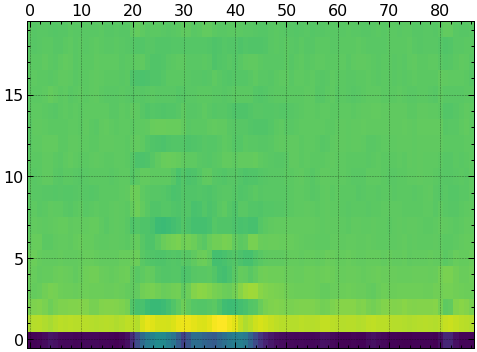

In [23]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

waveform, sample_rate = librosa.core.load("data/resampled_goodorning.wav", sr=None)
features = librosa.feature.mfcc(waveform, sample_rate)
figure, ax = plt.subplots(1, 1)
ax.matshow(features, origin='lower', aspect='auto')